## Import Library

 This notebook trains CNN on pooled motor imagery dataset

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [1]:
pwd

'/home/berdakh/Insync/berdakho@gmail.com/Google Drive/__BCI_Pytorch/deepMI-notebook'

In [2]:
#%matplotlib qt 

In [3]:
import torch 
import itertools

import pandas as pd 
import pickle 

import numpy as np
import mne

## Load data 

In [4]:
def loaddat(filename):        
    with open(filename, 'rb') as handle:
        b = pickle.load(handle)          
    return b

In [5]:
filename='aBNCI2014001R.pickle'
d = loaddat(filename)

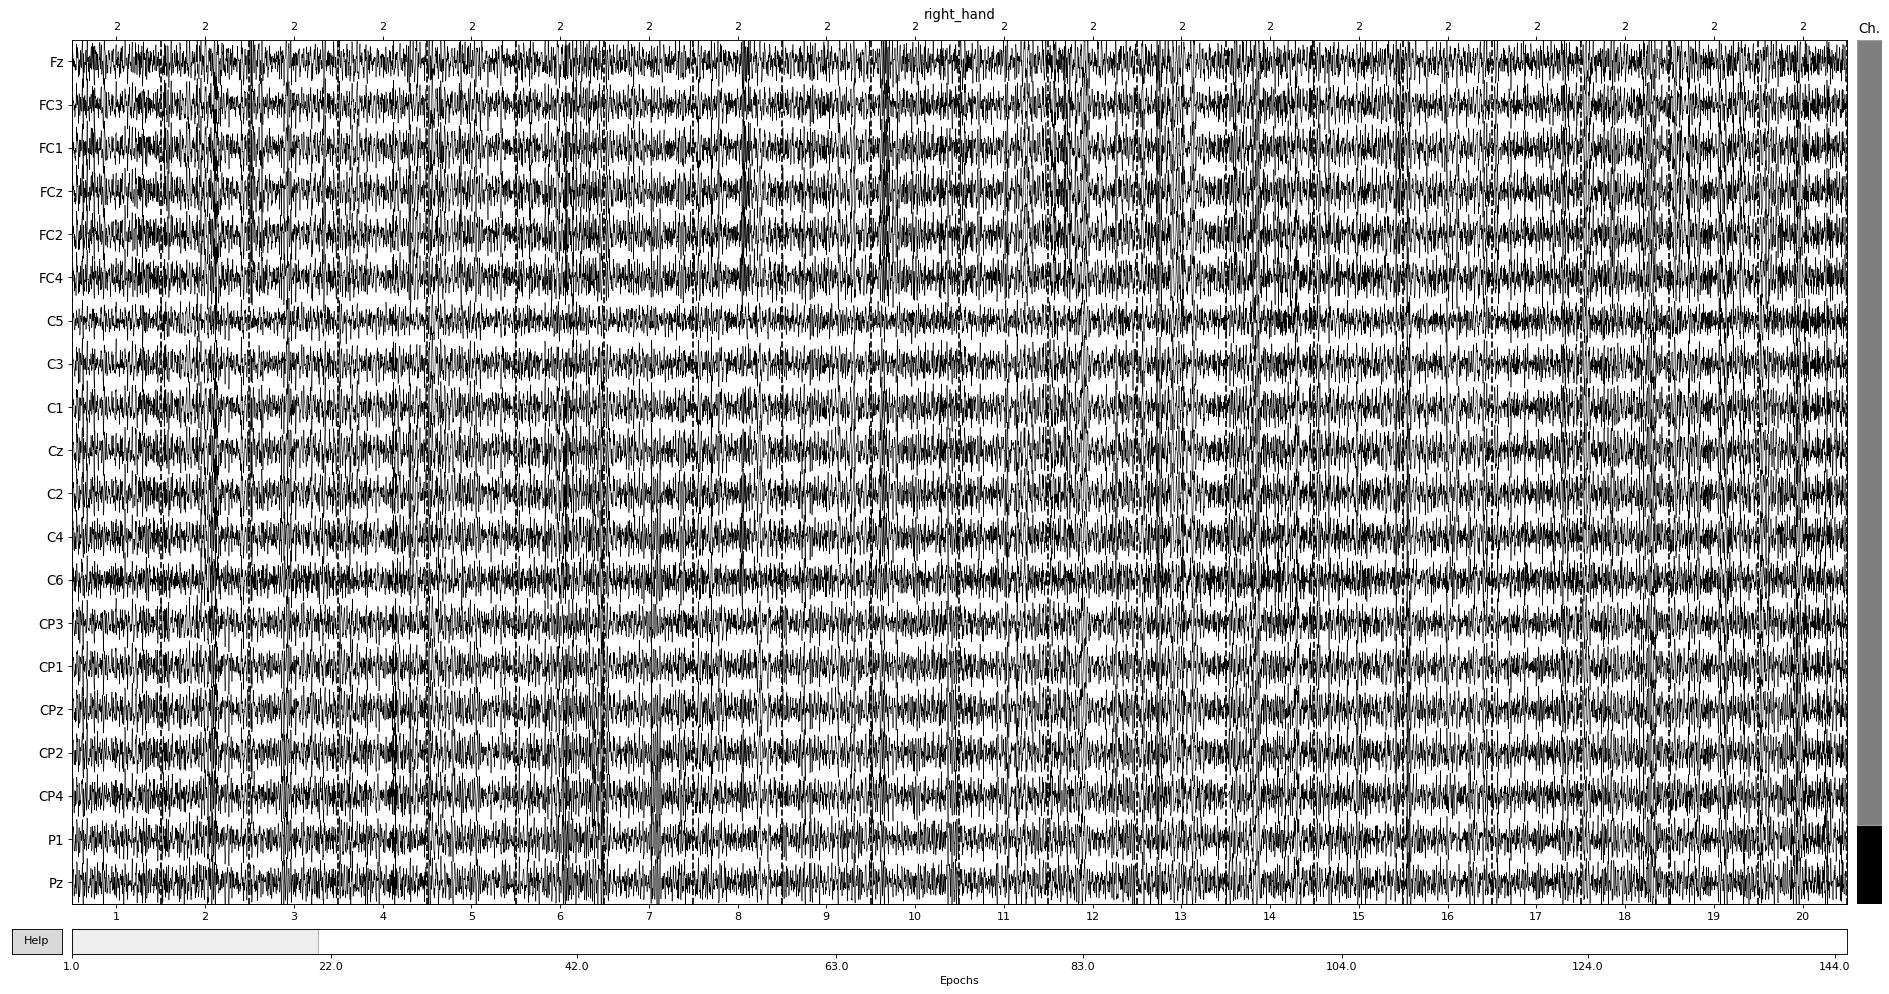

In [9]:
d[0]['right_hand'].plot();

## Select Dataset 


In [10]:
dname = dict(BNCI2014004 = 'aBNCI2014004R.pickle',
             BNCI2014001 = 'aBNCI2014001R.pickle',
             Weibo2014   = 'aWeibo2014R.pickle',
             Physionet   = 'aPhysionetRR.pickle')

In [11]:
# itemname is one of : ['BNCI2014004', 'BNCI2014001', 'Weibo2014', 'Physionet']
itemname = 'BNCI2014004'
filename = dname[itemname]
iname = itemname + '__'    

In [12]:
data = loaddat(filename)

In [13]:
data

[<Epochs  |   720 events (all good), 3.5 - 7.5 sec, baseline off, ~5.3 MB, data loaded,
  'left_hand': 360
  'right_hand': 360>,
 <Epochs  |   680 events (all good), 3.5 - 7.5 sec, baseline off, ~5.0 MB, data loaded,
  'left_hand': 340
  'right_hand': 340>,
 <Epochs  |   720 events (all good), 3.5 - 7.5 sec, baseline off, ~5.3 MB, data loaded,
  'left_hand': 360
  'right_hand': 360>,
 <Epochs  |   740 events (all good), 3.5 - 7.5 sec, baseline off, ~5.5 MB, data loaded,
  'left_hand': 370
  'right_hand': 370>,
 <Epochs  |   740 events (all good), 3.5 - 7.5 sec, baseline off, ~5.5 MB, data loaded,
  'left_hand': 370
  'right_hand': 370>,
 <Epochs  |   720 events (all good), 3.5 - 7.5 sec, baseline off, ~5.3 MB, data loaded,
  'left_hand': 360
  'right_hand': 360>,
 <Epochs  |   720 events (all good), 3.5 - 7.5 sec, baseline off, ~5.3 MB, data loaded,
  'left_hand': 360
  'right_hand': 360>,
 <Epochs  |   760 events (all good), 3.5 - 7.5 sec, baseline off, ~5.6 MB, data loaded,
  'left_h

### Load pooled data


In [14]:
from nu_smrutils import load_pooled, augment_dataset, crop_data

In [15]:
subjectIndex = list(range(108))
class_name = ['left_hand', 'right_hand']

dat = load_pooled(data, subjectIndex, class_name, 
                  normalize = True, test_size = 0.15)


### Data augmentation 

In [16]:
print(dat.keys())
dat['xtrain'].shape

dict_keys(['xtrain', 'xvalid', 'xtest', 'ytrain', 'yvalid', 'ytest'])


torch.Size([4433, 3, 321])

In [17]:
augment_dataset?

Signature: augment_dataset(X, Y, std_dev, multiple)
Docstring:
Augments the size of the dataset by introducing unbiased gaussian noise.
Resulting dataset is 'multiple' times bigger than original.
Args:
    X (torch.FloatTensor): Input training data
    Y (torch.FloatTensor): Target training data
    
    std_dev (float): Standard deviation of gaussian noise to apply
    multiple (int): Factor by how much the dataset should be bigger
File:      ~/Insync/berdakho@gmail.com/Google Drive/__BCI_Pytorch/Deep_MIpaper/nu_smrutils.py
Type:      function


In [18]:
augdata = dict(std_dev = 0.01, multiple = 2)

In [19]:
xtrain, ytrain = augment_dataset(dat['xtrain'], dat['ytrain'], 
                                 augdata['std_dev'], augdata['multiple'])
print(xtrain.shape)
dat['xtrain'], dat['ytrain'] = xtrain, ytrain

torch.Size([8866, 3, 321])


### Data Cropping

In [20]:
fs = 80 # sampling frequency 
crop_len = 1.5 #or None
crop = dict(fs = fs, crop_len = crop_len)

if crop['crop_len']:
   X_train, y_train = crop_data(crop['fs'],crop['crop_len'],dat['xtrain'],dat['ytrain'])
   X_valid, y_valid = crop_data(crop['fs'],crop['crop_len'],dat['xvalid'],dat['yvalid'])
   X_test,  y_test  = crop_data(crop['fs'],crop['crop_len'],dat['xtest'], dat['ytest'])

   dat = dict(xtrain = X_train, xvalid = X_valid, xtest = X_test,
              ytrain = y_train, yvalid = y_valid, ytest = y_test)

In [21]:
print('data shape after cropping :',dat['xtrain'].shape)

data shape after cropping : torch.Size([17732, 3, 180])


### Pytorch dataloaders 

In [22]:
from torch.utils.data import TensorDataset, DataLoader  

def get_data_loaders(dat, batch_size, EEGNET = None):
    
    # convert data dimensions to into to gray scale image format
    if EEGNET: ### EEGNet model requires the last dimension to be 1 
        ff = lambda dat: torch.unsqueeze(dat, dim = -1)    
    else:
        ff = lambda dat: torch.unsqueeze(dat, dim = 1)    
    
    x_train, x_valid, x_test = map(ff,(dat['xtrain'], dat['xvalid'],dat['xtest']))    
    y_train, y_valid, y_test = dat['ytrain'], dat['yvalid'], dat['ytest']
    print('Input data shape', x_train.shape)       
    
    # TensorDataset & Dataloader    
    train_dat    = TensorDataset(x_train, y_train) 
    val_dat      = TensorDataset(x_valid, y_valid) 
    
    train_loader = DataLoader(train_dat, batch_size = batch_size, shuffle = True)
    val_loader   = DataLoader(val_dat,   batch_size = batch_size, shuffle = False)

    output = dict(dset_loaders = {'train': train_loader, 'val': val_loader}, 
                  dset_sizes  =  {'train': len(x_train), 'val': len(x_valid)},
                  test_data   =  {'x_test' : x_test, 'y_test' : y_test})          
    return output 

In [23]:
dat = get_data_loaders(dat, batch_size = 64)
dat.keys()

Input data shape torch.Size([17732, 1, 3, 180])


dict_keys(['dset_loaders', 'dset_sizes', 'test_data'])

## CNN model

In [24]:
import torch.nn as nn

class CNN2D(torch.nn.Module):  
    def __init__(self, input_size, kernel_size, conv_channels, dense_size, dropout):         
        super(CNN2D, self).__init__()                  
        self.cconv   = []  
        self.MaxPool = nn.MaxPool2d((1, 2), (1, 2))  
        self.ReLU    = nn.ReLU()
        self.Dropout = nn.Dropout(dropout)        
        self.batchnorm = []                
        # ############ batchnorm ###########
        for jj in conv_channels:
            self.batchnorm.append(nn.BatchNorm2d(jj, eps=0.001, momentum=0.01,
                                                 affine=True, track_running_stats=True).cuda())     
        # ############ define CONV layer architecture: #########
        ii = 0
        for in_channels, out_channels in zip(conv_channels, conv_channels[1:]):                           
            conv_i = torch.nn.Conv2d(in_channels = in_channels, out_channels = out_channels,
                                     kernel_size = kernel_size[ii], #stride = (1, 2),
                                     padding     = (kernel_size[ii][0]//2, kernel_size[ii][1]//2))            
            self.cconv.append(conv_i)                
            self.add_module('CNN_K{}_O{}'.format(kernel_size[ii], out_channels), conv_i)
            ii += 1                            
        self.flat_dim = self.get_output_dim(input_size, self.cconv)    
        self.fc1 = torch.nn.Linear(self.flat_dim, dense_size)
        self.fc2 = torch.nn.Linear(dense_size, 2)                

    def get_output_dim(self, input_size, cconv):        
        with torch.no_grad():
            input = torch.ones(1,*input_size)              
            for conv_i in cconv:                
                input = conv_i(input)
                input = self.MaxPool(input)        
                flatout = int(np.prod(input.size()[1:]))
                print(input.shape)
                print("Flattened output ::", flatout)                
        return flatout 
        
    def forward(self, input):        
        for jj, conv_i in enumerate(self.cconv):
            input = conv_i(input)
            input = self.batchnorm[jj+1](input)
            input = self.ReLU(input)        
            input = self.MaxPool(input)                   
        # flatten the CNN output     
        out = input.view(-1, self.flat_dim) 
        out = self.fc1(out)                       
        out = self.Dropout(out)        
        out = self.fc2(out)      
        return out        

### Hyperparameter settings

In [25]:
import torch 
torch.manual_seed(0)
from nu_train_utils import train_model 

In [26]:
from nu_train_utils import train_model   
 
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Your GPU device name :', torch.cuda.get_device_name())    
torch.manual_seed(0)

Your GPU device name : GeForce GTX 1050 Ti


In [27]:
num_epochs = 150 
learning_rate = 1e-3
weight_decay = 1e-4  
batch_size = 64
verbose = 1

#% used to save the results table 
results = {}        
table = pd.DataFrame(columns = ['Train_Acc', 'Val_Acc', 'Test_Acc', 'Epoch'])   

#% get input size (channel x timepoints)
input_size = (1, dat['test_data']['x_test'].shape[-2], 
                 dat['test_data']['x_test'].shape[-1])
print(input_size)

(1, 3, 180)


In [28]:
# define kernel size in terms of ms length 
timE = 100 #ms
width = timE*fs//1000    

# width = 8 #timelength//chans         
# convolution parameters 
h1, w1 = 3, 1
h2, w2 = 3, 3
h3, w3 = 3, 5       

In [29]:
# one should run this script twice with ConvDown = True or False 
# to have different convolutional layer patterns  
ConvDOWN = True  

if ConvDOWN:            
    params = {'conv_channels': [
                                [1, 16, 8],                                               
                                [1, 32, 16, 8],
                                [1, 64, 32, 16, 8],
                                [1, 128, 64, 32, 16, 8],
                                [1, 256, 128, 64, 32, 16, 8]                                     
                                ],                         

              'kernel_size':    [[(h1, w1*width), (h1, w1*width), (h1, w1*width),(h1, w1*width),(h1, w1*width),(h1, w1*width)],
                                 [(h2, w2*width), (h2, w2*width), (h2, w2*width),(h2, w2*width),(h2, w2*width),(h2, w2*width)],
                                 [(h3, w3*width), (h3, w3*width), (h3, w3*width),(h3, w3*width),(h3, w3*width),(h3, w3*width)]]                                                                      
              }                      
else:                      
    params = {'conv_channels': [
                                [1, 8, 16],                                                  
                                [1, 8, 16, 32],
                                [1, 8, 16, 32, 64],
                                [1, 8, 16, 32, 64, 128],
                                [1, 8, 16, 32, 64, 128, 256]
                                ],      		

              'kernel_size':    [[(h1, w1*width), (h1, w1*width), (h1, w1*width),(h1, w1*width),(h1, w1*width),(h1, w1*width)],
                                 [(h2, w2*width), (h2, w2*width), (h2, w2*width),(h2, w2*width),(h2, w2*width),(h2, w2*width)],
                                 [(h3, w3*width), (h3, w3*width), (h3, w3*width),(h3, w3*width),(h3, w3*width),(h3, w3*width)]]                     
              }    
keys = list(params)

------------
## Training loop 

In [ ]:
for values in itertools.product(*map(params.get, keys)):
    d = dict(zip(keys, values))    
    description = 'C{}_K{}'.format(d['conv_channels'], d['kernel_size'][0])    
    print('\n\n##### ' + description + ' #####')

    # Define the architecture
    model = CNN2D(input_size    = input_size,
                  kernel_size   = d['kernel_size'], 
                  conv_channels = d['conv_channels'],
                  dense_size    = 256,
                  dropout       = 0.5)               
    print("Model architecture >>>", model)

    # optimizer and the loss function definition 
    optimizer = torch.optim.Adam(model.parameters(), 
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    criterion = torch.nn.CrossEntropyLoss()

    # move the model to GPU/CPU
    model.to(dev)  
    criterion.to(dev)       

    #******** Training loop *********    
    best_model, train_losses, val_losses, train_accs, val_accs, info =\
        train_model(model, dat['dset_loaders'], dat['dset_sizes'], 
                    criterion, optimizer, dev, lr_scheduler = None, 
                    num_epochs = num_epochs, verbose = verbose)    

    test_samples = 100
    x_test = dat['test_data']['x_test'][:test_samples,:,:,:] 
    y_test = dat['test_data']['y_test'][:test_samples] 
    
    # predict test data 
    preds = best_model(x_test.to(dev)) 
    preds_class = preds.data.max(1)[1]

    # get the accuracy 
    corrects = torch.sum(preds_class == y_test.data.to(dev))     
    test_acc = corrects.cpu().numpy()/x_test.shape[0]
    print("Test Accuracy :", test_acc) 

    # save results       
    tab = dict(Train_Acc= train_accs[info['best_epoch']],
               Val_Acc  = val_accs[info['best_epoch']],   
               Test_Acc = test_acc, Epoch = info['best_epoch'] + 1)         

    table.loc[description] = tab  
    val_acc = np.max(val_accs)

    print(table)
    results[description] = dict(train_accs = train_accs, val_accs =  val_accs,                                
                                ytrain = info['ytrain'], yval= info['yval'])      
    
    # save the best model weights
    fname = 'm_' + iname + 'CNN_POOLED' + description + '_' + str(val_acc)[:4]
    torch.save(best_model.state_dict(), fname) 

In [ ]:
dev

### Save results

In [27]:
rTable = dict(table = table)
ij = str(np.random.randint(101))
filename = iname + "_CNNPOOLEDRES_"+description +ij+ 'ConvDown' + str(ConvDOWN)         

with open(filename, 'wb') as ffile:
    pickle.dump(rTable, ffile)   